### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

### Inputs

In [2]:
inference_output_df = pd.read_csv("../outputs/inference_output.csv")
inference_output_class = inference_output_df['class'].values
inference_output_confidence = inference_output_df['confidence'].values

In [3]:
fusion_output_df = pd.read_csv("../outputs/fusion_output.csv")
fusion_output_class = fusion_output_df['class'].values
fusion_output_confidence = fusion_output_df['confidence'].values

In [4]:
kalman_output_df = pd.read_csv("../outputs/kalman_output.csv")
kalman_output_class = kalman_output_df['class'].values
kalman_output_confidence = kalman_output_df['confidence'].values

### Confiança: GNN vs Fusão vs Kalman

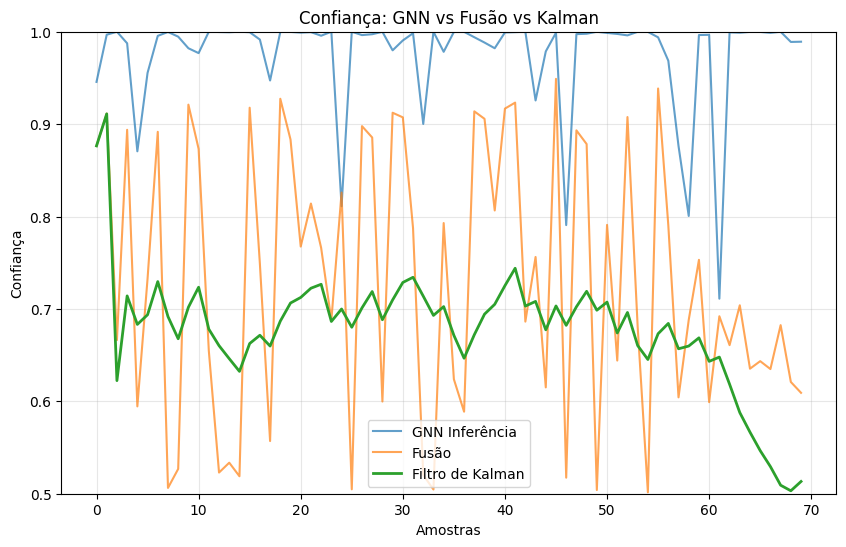

In [5]:
plt.figure(figsize=(10,6))

plt.plot(inference_output_confidence, label="GNN Inferência", alpha=0.7)
plt.plot(fusion_output_confidence, label="Fusão", alpha=0.7)
plt.plot(kalman_output_confidence, label="Filtro de Kalman", linewidth=2)

plt.title("Confiança: GNN vs Fusão vs Kalman")
plt.xlabel("Amostras")
plt.ylabel("Confiança")

plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0.5, 1)

plt.show()

### Confiança: GNN vs Fusão vs Kalman (primeiras 10 amostras)

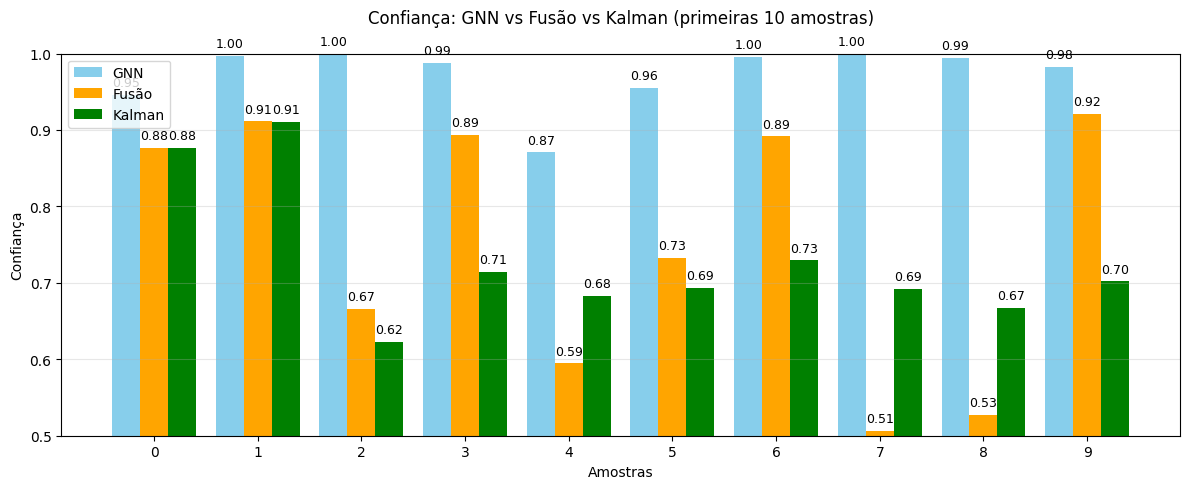

In [6]:
N = min(10, len(inference_output_confidence))
idx = np.arange(N)
ml_10  = np.array(inference_output_confidence[:N])
fus_10 = np.array(fusion_output_confidence[:N])
kal_10 = np.array(kalman_output_confidence[:N])

bar_w = 0.27
fig, ax = plt.subplots(figsize=(12, 5))
b1 = ax.bar(idx - bar_w, ml_10,  width=bar_w, label="GNN", color='skyblue')
b2 = ax.bar(idx, fus_10, width=bar_w, label="Fusão", color='orange')
b3 = ax.bar(idx + bar_w,  kal_10, width=bar_w, label="Kalman", color='green')

# Ajuste do eixo Y para mostrar apenas de 0.5 a 1
ymin = 0.5
ymax = 1.0
ax.set_ylim(ymin, ymax)

# Definir ticks entre 0.5 e 1.0
ticks = np.linspace(0.5, 1.0, 6)  # 0.5, 0.6, 0.7, 0.8, 0.9, 1.0
ax.set_yticks(ticks)
ax.set_yticklabels([f"{t:.1f}" for t in ticks])

# Distância para as anotações
dy = 0.015 * (ymax - ymin)

def annotate_bars(bars, fmt="{:.2f}", delta=dy):
    for bar in bars:
        h = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2., h + delta,
            fmt.format(h),
            ha="center", va="bottom", fontsize=9, clip_on=False
        )

annotate_bars(b1)
annotate_bars(b2)
annotate_bars(b3)

plt.title("Confiança: GNN vs Fusão vs Kalman (primeiras 10 amostras)", pad=22)
plt.xlabel("Amostras")
plt.ylabel("Confiança")

plt.xticks(idx, [str(i) for i in idx])
plt.legend(loc="upper left")

plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()

plt.show()

### Classificação: GNN vs Fusão vs Kalman

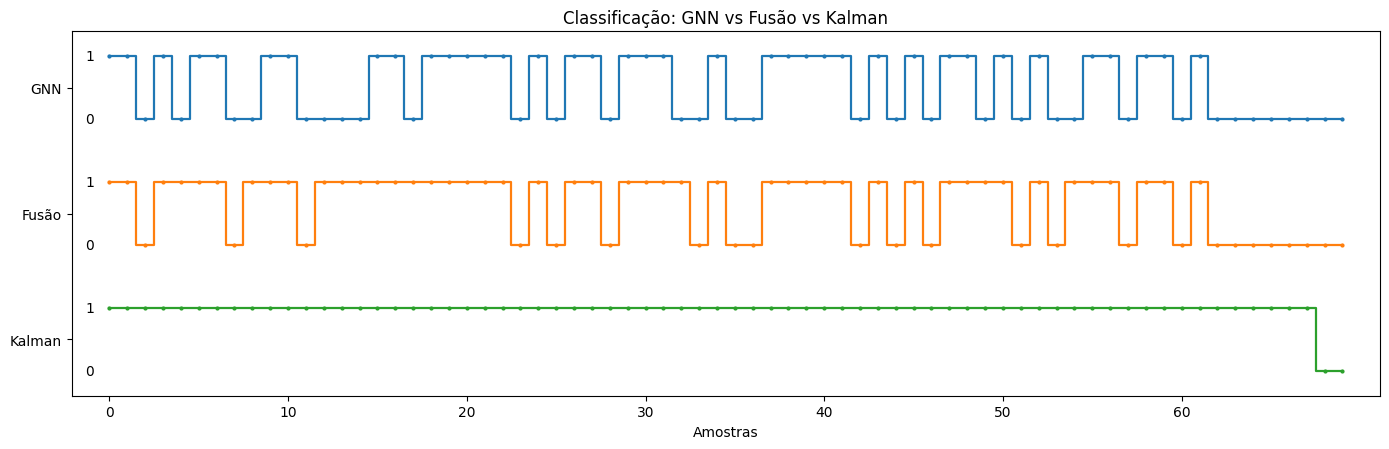

In [7]:
inf = np.asarray(inference_output_class).astype(int)
fus = np.asarray(fusion_output_class).astype(int)
kal = np.asarray(kalman_output_class).astype(int)
N = min(len(inf), len(fus), len(kal))
inf, fus, kal = inf[:N], fus[:N], kal[:N]

x = np.arange(0, N)

colors = {"GNN":"tab:blue", "Fusão":"tab:orange", "Kalman":"tab:green"}

plt.figure(figsize=(14, 4.6))
ax = plt.gca()

rows = [
    ("Kalman", kal, 0.0),
    ("Fusão",  fus, 2.0),
    ("GNN",    inf, 4.0),
]

for lab, yvals, yoff in rows:
    ax.plot(
        x, yoff + yvals,
        drawstyle="steps-mid",
        linewidth=1.6,
        marker="o", markersize=2,
        color=colors[lab], label=lab
    )

ax.set_yticks([0.5, 2.5, 4.5])
ax.set_yticklabels(["Kalman", "Fusão", "GNN"])

ax.set_xlabel("Amostras")
ax.set_title("Classificação: GNN vs Fusão vs Kalman")

pad = 0.03 * N
ax.set_xlim(0 - pad, (N-1) + pad)
ax.set_ylim(-0.4, 5.4)

ax.set_xticks(np.arange(0, N, 10))

xlab = 0 - pad*0.4  # mudança aqui: posição relativa ao pad

for _, _, yoff in rows:
    ax.text(xlab, yoff + 0, "0", va="center", ha="right")
    ax.text(xlab, yoff + 1, "1", va="center", ha="right")

plt.tight_layout()
plt.show()

### Classificação: GNN vs Fusão vs Kalman (primeiras 10 amostras)

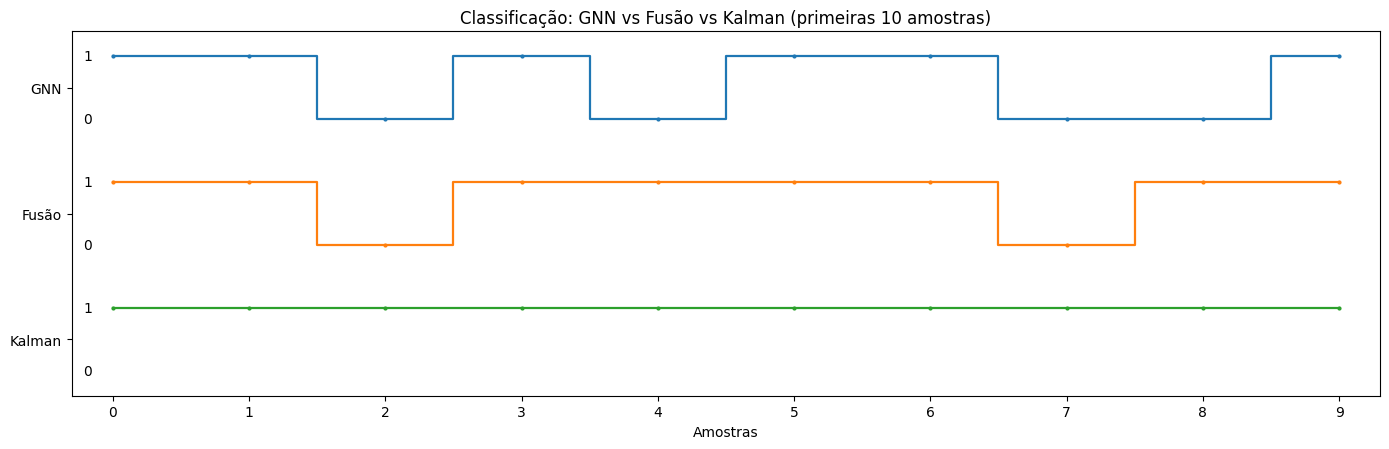

In [8]:
inf = np.asarray(inference_output_class).astype(int)
fus = np.asarray(fusion_output_class).astype(int)
kal = np.asarray(kalman_output_class).astype(int)

N = min(len(inf), len(fus), len(kal))
N10 = min(10, N)
inf, fus, kal = inf[:N10], fus[:N10], kal[:N10]

x = np.arange(0, N10)

colors = {"GNN":"tab:blue", "Fusão":"tab:orange", "Kalman":"tab:green"}

plt.figure(figsize=(14, 4.6))
ax = plt.gca()

rows = [
    ("Kalman", kal, 0.0),
    ("Fusão",  fus, 2.0),
    ("GNN",    inf, 4.0),
]

for lab, yvals, yoff in rows:
    ax.plot(x, yoff + yvals, drawstyle="steps-mid",
            linewidth=1.6, marker="o", markersize=2,
            color=colors[lab], label=lab)

ax.set_yticks([0.5, 2.5, 4.5])
ax.set_yticklabels(["Kalman", "Fusão", "GNN"])
ax.set_xlabel("Amostras")
ax.set_title("Classificação: GNN vs Fusão vs Kalman (primeiras 10 amostras)")

pad = 0.03 * N10
ax.set_xlim(0 - pad, (N10-1) + pad)
ax.set_ylim(-0.4, 5.4)

ax.set_xticks(np.arange(0, N10, 1))

xlab = -0.15
for _, _, yoff in rows:
    ax.text(xlab, yoff + 0, "0", va="center", ha="right")
    ax.text(xlab, yoff + 1, "1", va="center", ha="right")

plt.tight_layout()
plt.show()